从零实现

In [ ]:
!pip install d2l==0.14
!pip install git+https://github.com/d2l-ai/d2l-zh@release

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
def batch_norm(X,gamma,beta,moving_mean,moving_var,eps,momentum):#这里的两个均值和方差指代全局的均值和方差，可以认为是整个数据集的。
  if not torch.is_grad_enabled():#没有进行梯度更新的时候
    X_hat=(X-moving_mean)/torch.sqrt(moving_var+eps)
  else:
    assert len(X.shape) in (2,4)#全连接层或卷积层
    if len(X.shape)==2:
      mean=X.mean(dim=0)#按行算，即每一列的所有行算均值，每列表示一个特征
      var=((X-mean)**2).mean(dim=0)
    else:
      mean=X.mean(dim=(0,2,3),keepdim=True)#按通道算
      var=((X-mean)**2).mean(dim=(0,2,3),keepdim=True)
    X_hat=(X-mean)/torch.sqrt(var+eps)
    moving_mean=momentum*moving_mean+(1.0-momentum)*mean
    moving_var=momentum*moving_var+(1.0-momentum)*var
  Y=gamma*X_hat+beta
  return Y,moving_mean.data,moving_var.data

创建一个正确的BatchNorm图层

In [4]:
class BatchNrom(nn.Module):
  def __init__(self,num_features,num_dims):
    super().__init__()
    if num_dims==2:
      shape=(1,num_features)
    else:
      shape=(1,num_features,1,1)
    self.gamma=nn.Parameter(torch.ones(shape))
    self.beta=nn.Parameter(torch.zeros(shape))
    self.moving_mean=torch.zeros(shape)
    self.moving_var=torch.ones(shape)
  
  def forward(self,X):
    if self.moving_mean.device!=X.device:
      self.moving_mean=self.moving_mean.to(X.device)
      self.moving_var=self.moving_var.to(X.device)
    Y,self.moving_mean,self.moving_var=batch_norm(X,self.gamma,self.beta,self.moving_mean,self.moving_var,eps=1e-5,momentum=0.9)
    return Y

应用BatchNorm于LeNet模型

In [5]:
net=nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5),BatchNrom(6,num_dims=4),
    nn.Sigmoid(),nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),BatchNrom(16,4),
    nn.Sigmoid(),nn.MaxPool2d(2,2),
    nn.Flatten(),nn.Linear(16*4*4,120),
    BatchNrom(120,2),nn.Sigmoid(),
    nn.Linear(120,84),BatchNrom(84,2),nn.Sigmoid(),
    nn.Linear(84,10)
)

在Fashion-MNIST数据集上训练网络

loss 0.242, train acc 0.912, test acc 0.854
12936.6 examples/sec on cuda:0


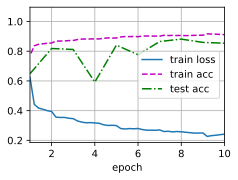

In [8]:
lr,num_epochs,batch_size=1.0,10,256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

拉伸参数gamma和偏移参数beta

In [7]:
net[1].gamma.reshape((-1,)),net[1].beta.reshape((-1,))

(tensor([1.3096, 1.8797, 2.5460, 2.3494, 1.4597, 0.7478], device='cuda:0',
        grad_fn=<ViewBackward>),
 tensor([-0.7508,  0.0424,  1.8219,  0.8607, -0.5023,  0.0033], device='cuda:0',
        grad_fn=<ViewBackward>))

简明实现

In [9]:
net=nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5),nn.BatchNorm2d(6),
    nn.Sigmoid(),nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),nn.BatchNorm2d(16),
    nn.Sigmoid(),nn.MaxPool2d(2,2),
    nn.Flatten(),nn.Linear(16*4*4,120),
    nn.BatchNorm1d(120),nn.Sigmoid(),
    nn.Linear(120,84),nn.BatchNorm1d(84),nn.Sigmoid(),
    nn.Linear(84,10)
)

loss 0.249, train acc 0.909, test acc 0.867
23790.0 examples/sec on cuda:0


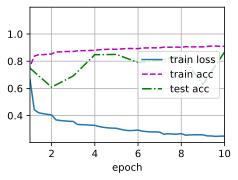

In [10]:
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())